In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from in_progress.regularizers import LieDerivativeRegularizer, CurvatureRegularizer, _compute_jet
from in_progress.utils.ring_attractor_data import data_gen
from in_progress.test_dynamics import WarpedRingAttractorRNN, RNNToODE, RbfPerturbedRingAttractorODE  # noqa
from functools import partial
import torch
from torch import Tensor
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from in_progress.visualize_regularizers import compute_vector_field_grid
from typing import Optional
from functools import partial
import warnings
from torch.nn import functional as TF
from torch import linalg as TL

In [22]:
old = np.mgrid[-2:2:100j, -2:2:100j]
pts = torch.tensor(np.moveaxis(old, 0, -1).reshape(-1, 2), dtype=torch.float32)

In [23]:


def _rosenbrock(x: Tensor, alpha: Optional[float] = None) -> Tensor:
    if alpha is None:
        alpha = 0.0
    x_coord = x[..., 0]
    y_coord = x[..., 1]
    grad_x = - alpha * (2 * (1 - x_coord)) - 4 * x_coord * (y_coord - x_coord ** 2)
    grad_y = 2 * (y_coord - x_coord ** 2)
    gradient = torch.stack([grad_x, grad_y], dim=-1)
    return - gradient


ra = RbfPerturbedRingAttractorODE(perturbation_magnitude=0)
old = np.mgrid[-2:2:100j, -2:2:100j]

stream_F = lambda F_: compute_vector_field_grid(F_, (-2, 2), n_points=100, device=None)

In [24]:
import torch
from torch.func import jacrev, jvp


def kcc_curvature(f, x):
    """
    Compute Kosambi-Cartan-Chern (KCC) curvature at p __x for ODE: dx/dt = f(__x).

    Args:
        f: Callable, vector field f(__x) -> tensor of shape (n,)
        x: Tensor of shape (n,), the state at which to compute curvature

    Returns:
        P: Tensor of shape (n, n), the KCC curvature matrix
    """
    # Compute v = f(__x) along the flow
    v = f(x)

    # Define Jacobian of f
    jac_f = jacrev(f)

    # Term 1: (1/2) * directional derivative of Jacobian along v
    _, dJ = jvp(jac_f, (x,), (v,))  # shape (n, n)
    term1 = 0.5 * dJ

    # Term 2: (1/4) * J @ J
    J = jac_f(x)  # shape (n, n)
    term2 = 0.25 * (J @ J)

    return term1 + term2


def kcc_curvature_eigvals(f, x):
    P = kcc_curvature(f, x)
    return TL.eigvals(P)


x = torch.tensor([1.0, 0.5], requires_grad=True)
P = kcc_curvature(lds, x)

print("KCC curvature P:\n", P)

KCC curvature P:
 tensor([[0.0359, 0.0332],
        [0.0183, 0.0208]])


In [ ]:
A = torch.randn(2, 2)

A = A.T - A
class LDS(torch.nn.Module):
    def __init__(self,A:Optional[Tensor]=None):
        super().__init__()
        if not A:
            A = torch.tensor([[0.0, -1.0], [1.0, 0.0]])
        self.A = A

    def forward(self, x: Tensor) -> Tensor:
        return x @ A

lds = LDS()


_order = 1
_alpha = 0.1
_F = lambda x: _rosenbrock(x, alpha=torch.tensor(_alpha))
F = ra

DF = torch.func.jacfwd(F)
results = torch.stack([
    # here `o` is old Python int, so matrix_power never needs to call .item()
    torch.vmap(lambda p: TL.matrix_power(DF(p), o) @ F(p))(pts)
    for o in range(0, 4)
], dim=-1)
J2 = _compute_jet(F, pts, order=4)
# R = lambda ord=0,J_=None: torch.vmap(lambda __x:kcc_curvature_eigvals(F, __x))(pts)[...,0].real.abs()
# R = lambda ord=0, J_=None: torch.vmap(lambda __x: kcc_curvature_eigvals(F, __x))(pts)[..., 1].real.abs()

R = lambda ord=0,J_=None:CurvatureRegularizer(f=F,order=1).eval_regularizer(pts)
# R = lambda ord=0,J_=None: torch.prod(torch.vmap(lambda __x:kcc_curvature_eigvals(F, __x))(pts), dim=-1).real.abs()
# R = lambda ord=0, J_=J2:(results[...,0:ord:]-J_[...,0:ord:]).norm(dim=(-2,-1)).square()
# R = lambda ord=0, J_=J2:1-(TF.cosine_similarity(J_.flatten(start_dim=-2), results.flatten(start_dim=-2), dim=-1)).abs()
# R = lambda ord=0, J_=J2:(TF.cosine_similarity(J_[...,ord], J_[...,ord+1], dim=-1)).abs()
# R = lambda ord=0, J_=J2:(1-(TF.cosine_similarity(J_[...,0], J_[...,ord], dim=-1)).abs())
# R = lambda ord=0, J_=J2:torch.linalg.vecdot(J_[...,ord], J_[...,ord+1], dim=-1).square()
# R = lambda ord=0, J_=J2:(J_[...,ord] / J_[...,ord+1]).norm(dim=-1)
# R = lambda ord=0, J_=J2:torch.linalg.vector_norm(J_[...,ord],dim=-1).square()


def _R(order: int = 0, J_: Optional[Tensor] = None) -> Tensor:
    if J_ is None:
        J_ = J2
    if order >= J_.shape[-1] - 1:
        warnings.warn("order > J_.shape[-1]")
        return R(J_.shape[-1] - 2, J_=J_)
    return R(order, J_=J_)


eps = np.finfo(np.float32).eps
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

xs, ys, u, v = stream_F(F)
norm1 = torch.stack((torch.tensor(u), torch.tensor(v)), dim=-1).norm(dim=-1).numpy()
norm2 = J2[..., _order].reshape(100, 100, 2).norm(dim=-1).T.numpy()
tmp = results
norm3 = results[..., _order].reshape(100, 100, 2).norm(dim=-1).T.numpy()

nmax = torch.cat((torch.tensor(norm1), torch.tensor(norm2), torch.tensor(norm3)), dim=0).max().numpy()

axs[0].streamplot(xs, ys, u, v, color=norm1, cmap='viridis', linewidth=0.5, norm=Normalize(0, nmax))
axs[0].set_title("Vector field")

axs[1].streamplot(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100), J2[:, 0, _order].numpy().reshape(100, 100).T,
                  J2[:, 1, _order].numpy().reshape(100, 100).T, color=norm2, cmap='viridis', linewidth=0.5,
                  norm=Normalize(0, nmax))
axs[1].set_title(f"{_order + 1}-th jet")

# tmp = torch.transpose(tmp, 0, 1)
# norm = tmp[:,_order].reshape(100,100).T.norm(dim=-1)
axs[2].streamplot(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100), tmp[:, 0, _order].numpy().reshape(100, 100).T,
                  tmp[:, 1, _order].numpy().reshape(100, 100).T, color=norm3, cmap='viridis', linewidth=0.5,
                  norm=Normalize(0, nmax))
axs[2].set_title(f"{_order + 1}-th deviation jet")

im1 = axs[-1].imshow(
    np.flipud(np.moveaxis((_R(_order, J2).reshape(100, 100).numpy()), -1, 0)), norm=LogNorm(vmin=2 * eps, clip=True),
    extent=(-2, 2, -2, 2))
fig.colorbar(im1, ax=axs[-1], orientation="vertical", shrink=0.6, aspect=30)

In [ ]:
********print(f'Max norm of v field {np.max(norm1)}')
print(f'Max norm of v field {np.max(norm2)}')
print(f'Max norm of v field {np.max(norm3)}')


In [ ]:
from in_progress.regularizers import _compute_jet_old, _compute_jet, _compute_jet_g_along_f

In [ ]:
order = 4
new = _compute_jet_g_along_f(F, F, pts, order=order)
jnorms: torch.Tensor = new.norm(dim=-2)
eps = 1e-8

# Compute global normalization range
data_np = jnorms.numpy()
global_min = data_np.min()
global_max = data_np.max()

# Create figure and axes
fig, axs = plt.subplots(1, order, figsize=(20, 6))

# Shared normalization
norm = LogNorm(vmin=max(global_min, 2 * eps), vmax=global_max)

for i in range(order):
    slice_data = data_np[..., i].reshape(100, 100)
    avg_norm = slice_data.mean()  # average norm for this slice

    img = axs[i].matshow(
        np.flipud(slice_data.T),
        norm=norm,
        extent=(-2, 2, -2, 2)
    )
    axs[i].set_title(f"Avg: {avg_norm:.2e}")  # scientific notation

# Add shared colorbar
fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02)
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math


def compute_taylor_contributions(jets: torch.Tensor, h: float) -> torch.Tensor:
    """
    jets: (..., order) tensor of raw jets (no factorial normalization)
    h: step size for Taylor contribution
    Returns: (..., order) contributions for each Taylor term
    """
    order = jets.shape[-1]
    contribs = []
    for k in range(order):
        term = jets[..., k] * (h ** (k + 1)) / math.factorial(k + 1)
        contribs.append(term.norm(dim=-1))  # norm over function dimension
    return torch.stack(contribs, dim=-1)  # (..., order)

In [ ]:
def plot_taylor_contributions(contribs: torch.Tensor, extent=(-2, 2, -2, 2)):
    """
    contribs: (N^2, order) tensor of contributions (after compute_taylor_contributions)
    """
    order = contribs.shape[-1]
    contrib_np = contribs.numpy()
    global_min, global_max = contrib_np.min(), contrib_np.max()

    fig, axs = plt.subplots(1, order, figsize=(20, 6))
    norm = LogNorm(vmin=max(global_min, 1e-12), vmax=global_max)

    for i in range(order):
        slice_data = contrib_np[..., i].reshape(100, 100).T  # reshape to grid
        avg_norm = slice_data.mean()
        img = axs[i].imshow(
            np.flipud(slice_data),
            norm=norm,
            extent=extent,
            aspect='auto'
        )
        axs[i].set_title(f"k={i + 1} Avg: {avg_norm:.2e}")

    fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02)
    plt.show()

In [ ]:
order = 4
jets_raw = _compute_jet_g_along_f(F, F, pts, order=order, normalize=False)
contribs = compute_taylor_contributions(jets_raw, h=0.01)
plot_taylor_contributions(contribs)

In [ ]:
def compute_radius_of_convergence(jets: torch.Tensor) -> torch.Tensor:
    """
    Estimate radius of convergence using truncated Cauchy-Hadamard formula.
    jets: (..., order) raw jets
    Returns: (...,) radius estimate for each p
    """
    order = jets.shape[-1]
    a = []
    for k in range(order):
        coeff_norm = jets[..., k].norm(dim=-1) / math.factorial(k + 1)
        a.append(coeff_norm.pow(1.0 / (k + 1)))
    a = torch.stack(a, dim=-1)  # (..., order)
    return 1.0 / a.max(dim=-1).values  # radius = 1 / max_root


def plot_radius_of_convergence(radius: torch.Tensor, extent=(-2, 2, -2, 2)):
    rad_np = radius.numpy()
    fig, ax = plt.subplots(figsize=(6, 6))
    img = ax.imshow(
        np.flipud(rad_np.reshape(100, 100).T),
        norm=LogNorm(vmin=max(rad_np.min(), 1e-8), vmax=rad_np.max()),
        extent=extent,
        aspect='auto'
    )
    ax.set_title("Estimated Radius of Convergence")
    fig.colorbar(img, ax=ax, orientation='vertical')
    plt.show()


def compute_radius_of_convergence_from_ode_jets(jets: torch.Tensor) -> torch.Tensor:
    """
    Estimate radius of convergence for ODE solution using Faà di Bruno jets.

    jets: (..., order) raw derivatives of the solution (not normalized).
    Returns: (...,) radius estimate for each p in the grid.
    """
    order = jets.shape[-1]
    roots = []
    for k in range(order):
        coeff_norm = jets[..., k].norm(dim=-1) / math.factorial(k + 1)
        roots.append(coeff_norm.pow(1.0 / (k + 1)))  # (k+1) because index starts at 0
    roots = torch.stack(roots, dim=-1)  # shape (..., order)
    return 1.0 / roots.max(dim=-1).values


def detect_slow_regions(jets: torch.Tensor, threshold_ratio=0.1, min_radius=10.0):
    """
    jets: (..., order) raw jets
    threshold_ratio: ratio cutoff for slow detection
    min_radius: minimum radius for slow classification
    """
    order = jets.shape[-1]
    norms = [jets[..., k].norm(dim=-1) / math.factorial(k + 1) for k in range(order)]
    norms = torch.stack(norms, dim=-1)  # (..., order)

    ratios = norms[..., 1:] / (norms[..., :-1] + 1e-12)  # consecutive ratios
    r1 = ratios[..., 0]  # ratio of 2nd to 1st term
    radius = compute_radius_of_convergence_from_ode_jets(jets)

    slow_mask = (r1 < threshold_ratio) & (radius > min_radius)
    return slow_mask, r1, radius

In [ ]:
a = 0
ord = 3
_F = lambda x: _rosenbrock(x, alpha=torch.tensor(a))
F = _F

jets_raw = _compute_jet_g_along_f(F, F, pts, order=ord, normalize=False)

radius = compute_radius_of_convergence(jets_raw)
plot_radius_of_convergence(radius)
contribs = compute_taylor_contributions(jets_raw, h=0.01)
plot_taylor_contributions(contribs)
# Compute raw jets for f
jets_raw = _compute_jet(F, pts, order=4)  # your original function, normalize=False
radius = compute_radius_of_convergence_from_ode_jets(jets_raw)

# Plot as heatmap
plot_radius_of_convergence(radius)
slow_mask, r1, radius = detect_slow_regions(jets_raw)
plt.imshow(slow_mask.reshape(100, 100).T, extent=(-2, 2, -2, 2), origin='lower', cmap='coolwarm')
plt.title("Detected Slow Regions")
plt.show()

In [ ]:
def radius_fn(x, f, order=4):
    """
    Compute radius of convergence at a single p x using jets of f.
    """
    jets = _compute_jet(f, x, order=order)  # raw derivatives
    roots = []
    for k in range(order):
        coeff_norm = jets[..., k].norm() / math.factorial(k + 1)
        roots.append(coeff_norm.pow(1.0 / (k + 1)))
    return 1.0 / torch.max(torch.stack(roots))


def compute_radius_and_gradient(f, pts, order=4):
    """
    Compute radius and its gradient via autodiff.
    pts: tensor of shape (batch, dim)
    """
    radii = []
    grads = []
    for x in pts:
        x = x.clone().detach().requires_grad_(True)
        R = radius_fn(x, f, order)
        grad = torch.autograd.grad(R, x, create_graph=False)[0]
        radii.append(R.detach())
        grads.append(grad.detach().norm())
    return torch.stack(radii), torch.stack(grads)

In [ ]:
radii, grad_norms = compute_radius_and_gradient(F, pts, order=4)

# Reshape for heatmap
radii_2d = radii.view(100, 100)
grad_2d = grad_norms.view(100, 100)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(radii_2d.T, extent=(-2, 2, -2, 2), origin='lower', norm=LogNorm(), cmap='viridis')
plt.title("Radius of Convergence")

plt.subplot(1, 2, 2)
plt.imshow(grad_2d.T, extent=(-2, 2, -2, 2), origin='lower', norm=LogNorm(), cmap='inferno')
plt.title("|∇ Radius| (Autodiff)")
plt.colorbar()
plt.show()

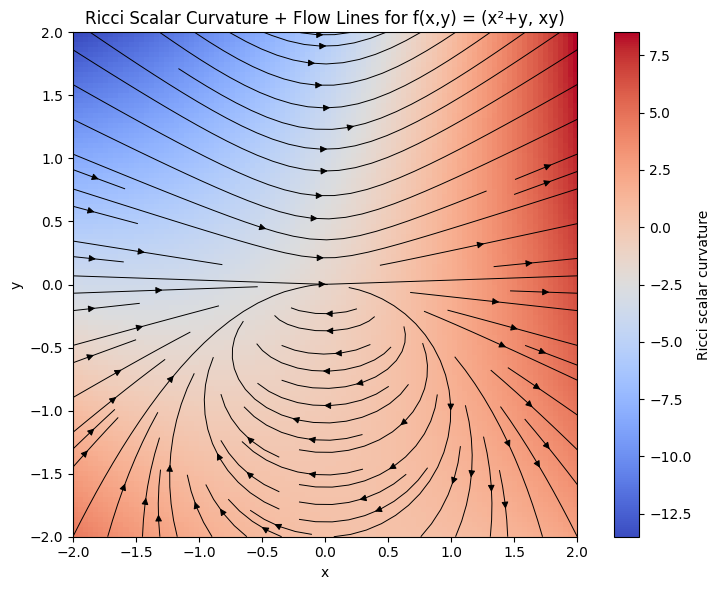

In [80]:
import torch
from torch.func import jacfwd, vmap
import matplotlib.pyplot as plt

import torch

def analytic_ricci_tensor(xy: torch.Tensor) -> torch.Tensor:
    """
    Compute the exact analytical Ricci tensor for the ODE:
        f(x,y) = (x^2 + y, xy)

    Args:
        xy: tensor of shape (..., 2), where last dim = [x, y]

    Returns:
        Ricci tensor: shape (..., 2, 2)
    """
    x, y = xy[..., 0], xy[..., 1]

    # R11
    R11 = (3/4)*x**2 + (3/2)*x*y - y - (1/4)*y**2 - 0.5
    # R12 = R21
    R12 = 0.5*(x - y)
    # R22
    R22 = 0.5*(5*x - y - 2)

    # Stack into (..., 2, 2)
    Ricci = torch.stack([torch.stack([R11, R12], dim=-1),
                          torch.stack([R12, R22], dim=-1)], dim=-2)
    return Ricci

def analytic_ricci_scalar(xy: torch.Tensor) -> torch.Tensor:
    """
    Compute Ricci scalar (trace) from the analytical formula.
    Args:
        xy: tensor (..., 2)
    Returns:
        scalar Ricci curvature
    """
    x, y = xy[..., 0], xy[..., 1]
    scalar = (3/4)*x**2 + (3/2)*x*y - (1/4)*y**2 + (5/2)*x - (3/2)*y - (3/2)
    return scalar

def compute_ricci_curvature(f, x):
    Df = jacfwd(f)(x)             # (n,n)
    D2f = jacfwd(jacfwd(f))(x)    # (n,n,n)
    Gamma = -0.5 * (Df[:, None, :] + Df[:, :, None])

    # term1: -0.5 * (∑_m D2f[m,j,m] + ∑_m D2f[m,l,m])
    sum_mjm = torch.sum(torch.diagonal(D2f, dim1=0, dim2=2), dim=0)  # shape (n,) for j
    sum_mlm = torch.sum(torch.diagonal(D2f, dim1=0, dim2=2), dim=0)  # same diagonal reuse
    term1 = -0.5 * (sum_mjm[:, None] + sum_mlm[None, :])  # (n,n)

    # term2: -0.5 * (∑_m D2f[m,j,l] + ∑_m D2f[m,m,l])
    sum_mjl = torch.sum(D2f, dim=0)  # sum over first index -> (n,n)
    sum_mml = torch.sum(torch.diagonal(D2f, dim1=0, dim2=1), dim=0)  # shape (n,)
    term2 = -0.5 * (sum_mjl + sum_mml[None, :])  # (n,n)

    # Quadratic part: (n,n)
    quad1 = torch.einsum('pjl,mpm->jl', Gamma, Gamma)
    quad2 = torch.einsum('pjm,mlp->jl', Gamma, Gamma)

    Ricci = term1 - term2 + (quad1 - quad2)  # (n,n)
    return Ricci


def ricci_scalar(Ricci):
    return torch.linalg.matrix_norm(Ricci, ord='fro') ** 2


def vector_field(x):
    return torch.stack([x[0] ** 2 + x[1], x[0] * x[1]])


res = 100
x_vals = torch.linspace(-2, 2, res)
y_vals = torch.linspace(-2, 2, res)
XX, YY = torch.meshgrid(x_vals, y_vals, indexing='xy')
points = torch.stack([XX.flatten(), YY.flatten()], dim=-1)  # shape (res^2, 2)

# Compute Ricci scalar at all grid points
scalar_fn = lambda pt: ricci_scalar(compute_ricci_curvature(vector_field, pt))
ricci_vals = vmap(scalar_fn)(points).reshape(res, res)
ricci_vals_analytical = vmap(analytic_ricci_scalar)(points).reshape(res, res)
# Compute vector field for streamplot
U = XX.numpy()**2 + YY.numpy()         # f1 = x^2 + y
V = (XX * YY).numpy()                  # f2 = x*y

# ---- Plot Ricci heatmap with streamplot ----
plt.figure(figsize=(8, 6))
plt.imshow(ricci_vals_analytical.numpy(), extent=[-2, 2, -2, 2], origin='lower', cmap='coolwarm')
plt.colorbar(label="Ricci scalar curvature")
plt.streamplot(x_vals.numpy(), y_vals.numpy(), U, V, color='k', density=1.0, linewidth=0.7, arrowsize=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ricci Scalar Curvature + Flow Lines for f(x,y) = (x²+y, xy)")
plt.tight_layout()
plt.show()

In [75]:
ricci_vals = vmap(lambda x:compute_ricci_curvature(vector_field, x))(points)
ricci_vals_analytical = vmap(analytic_ricci_tensor)(points)

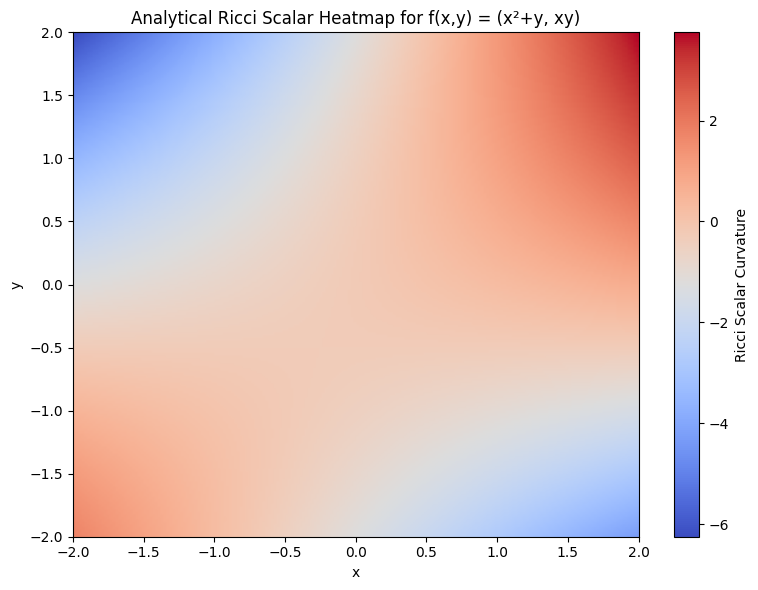

In [92]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import KroneckerDelta


# --- Step 1: Define symbolic Ricci tensor and scalar ---
def sympy_ricci_scalar():
    x, y = sp.symbols('x y')
    coords = [x, y]

    # Vector field f
    f = sp.Matrix([x**2 + y, x*y])
    Df = f.jacobian(coords)

    # Gamma tensor
    Gamma = sp.MutableDenseNDimArray.zeros(2, 2, 2)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                # Gamma[i, j, k] = -sp.Rational(1, 2)*(Df[i, j] + Df[i, k])
                Gamma[i,j,k] = -sp.Rational(1,2)*( Df[i,j]*KroneckerDelta(i,k)
                                + Df[i,k]*KroneckerDelta(i,j) )

    # Ricci tensor R_{jl}
    R = sp.MutableDenseNDimArray.zeros(2, 2)
    for j in range(2):
        for l in range(2):
            term1 = sum(sp.diff(Gamma[m, j, l], coords[m]) for m in range(2))
            term2 = sum(sp.diff(Gamma[m, j, m], coords[l]) for m in range(2))
            quad1 = sum(Gamma[p, j, l]*Gamma[m, p, m] for m in range(2) for p in range(2))
            quad2 = sum(Gamma[p, j, m]*Gamma[m, l, p] for m in range(2) for p in range(2))
            R[j, l] = sp.simplify(term1 - term2 + quad1 - quad2)

    Ricci_matrix = sp.Matrix([[R[0, 0], R[0, 1]], [R[1, 0], R[1, 1]]])
    Ricci_scalar = sp.simplify(Ricci_matrix.trace())
    return x, y, Ricci_scalar

# --- Step 2: Lambdify to NumPy function ---
x, y, Ricci_scalar_expr = sympy_ricci_scalar()
ricci_scalar_func = sp.lambdify((x, y), Ricci_scalar_expr, modules='numpy')

# --- Step 3: Create grid and evaluate ---
res = 200
x_vals = np.linspace(-2, 2, res)
y_vals = np.linspace(-2, 2, res)
X, Y = np.meshgrid(x_vals, y_vals)
Z = ricci_scalar_func(X, Y)  # Evaluate Ricci scalar on grid

# --- Step 4: Plot heatmap ---
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(Z, extent=[-2, 2, -2, 2], origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(heatmap, label="Ricci Scalar Curvature")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Ricci Scalar Heatmap for f(x,y) = (x²+y, xy)")
plt.tight_layout()
plt.show()

In [6]:
from in_progress.regularizers import _jvp

# Helper to compute DBx0^k f[v1, v2, ..., vk] or DBx0^k g[v1, v2, ..., vk]
def _nested_jvp(func, point, directions):
    """Compute higher order directional derivative."""
    if len(directions) == 0:
        return func(point)
    elif len(directions) == 1:
        return _jvp(func, (point,), (directions[0],))
    else:
        # Take derivative of the (k-1)-th order derivative
        inner_func = lambda y: _nested_jvp(func, y, directions[1:])
        return _jvp(inner_func, (point,), (directions[0],))

def _compute_jet_g_along_f_new(
    g, f, x: torch.Tensor, order: int, normalize: bool = True
) -> torch.Tensor:
    if order > 4:
        raise NotImplementedError("Jets higher than order 4 are not implemented.")

    def norm(term, k):
        return term if not normalize else term / math.factorial(k)

    # Define reusable derivative operators
    Df = lambda y, v: _jvp(f, (y,), (v,))
    Dg = lambda y, v: _jvp(g, (y,), (v,))

    # Compute f derivatives
    f1 = f(x)
    f2 = Df(x, f1)

    # Define higher order f derivatives
    Df_f1 = lambda y: Df(y, f1)
    Df_f2 = lambda y: Df(y, f2)
    Df_f3 = lambda y: Df(y, f3)  # forward reference

    D2f_f1 = lambda y, v: _jvp(Df_f1, (y,), (v,))

    # Compute f3 and f4
    f3 = Df(x, f2) + D2f_f1(x, f1)
    f4 = Df(x, f3) + 3 * D2f_f1(x, f2) + _jvp(lambda y: D2f_f1(y, f1), (x,), (f1,))

    # Store f-terms
    F = [None, f1, f2, f3, f4]
    jets = []

    # Define all g derivative operators upfront
    Dg_f1 = lambda y: Dg(y, F[1])
    Dg_f2 = lambda y: Dg(y, F[2])
    Dg_f3 = lambda y: Dg(y, F[3])
    Dg_f4 = lambda y: Dg(y, F[4])

    D2g_f1 = lambda y, v: _jvp(Dg_f1, (y,), (v,))
    D2g_f2 = lambda y, v: _jvp(Dg_f2, (y,), (v,))
    D3g_f1_f1 = lambda y, v: _jvp(lambda z: D2g_f1(z, F[1]), (y,), (v,))

    # g^(1): Dg[f1]
    g1 = Dg(x, F[1])
    jets.append(norm(g1, 1))

    if order >= 2:
        # g^(2): Dg[f2] + DBx0^2 g[f1,f1]
        g2 = Dg(x, F[2]) + D2g_f1(x, F[1])
        jets.append(norm(g2, 2))

    if order >= 3:
        # g^(3): Dg[f3] + 3 DBx0^2 g[f1,f2] + DBx0^3 g[f1,f1,f1]
        g3 = Dg(x, F[3]) + 3 * D2g_f1(x, F[2]) + D3g_f1_f1(x, F[1])
        jets.append(norm(g3, 3))

    if order >= 4:
        # g^(4): Dg[f4] + 4 DBx0^2 g[f1,f3] + 3 DBx0^2 g[f2,f2]
        #       + 6 DBx0^3 g[f1,f1,f2] + DBx0^4 g[f1,f1,f1,f1]
        g4 = (
            Dg(x, F[4]) +
            4 * D2g_f1(x, F[3]) +
            3 * D2g_f2(x, F[2]) +
            6 * D3g_f1_f1(x, F[2]) +
            _jvp(D3g_f1_f1, (x,), (F[1],))  # DBx0^4 g[f1,f1,f1,f1]
        )
        jets.append(norm(g4, 4))

    return torch.stack(jets, dim=-1)


In [19]:
torch.allclose(a,b)

True

In [8]:
import torch
import math
from typing import Callable, Any, Optional
from in_progress.regularizers import _compute_jet_g_along_f as _compute_jet_g_along_f_original



def test_jet_implementations():
    """Test that both implementations produce the same results."""
    torch.manual_seed(42)

    # Test different scenarios
    test_cases = []

    # Case 1: Simple polynomial functions
    def f_poly(x):
        return x ** 2 + 2 * x + 1

    def g_poly(x):
        return x ** 3 - x

    test_cases.append(("polynomial", f_poly, g_poly))

    # Case 2: Trigonometric functions
    def f_trig(x):
        return torch.sin(x)

    def g_trig(x):
        return torch.cos(x)

    test_cases.append(("trigonometric", f_trig, g_trig))

    # Case 3: Exponential functions
    def f_exp(x):
        return torch.exp(x)

    def g_exp(x):
        return torch.exp(-x)

    test_cases.append(("exponential", f_exp, g_exp))

    # Case 4: More complex composition
    def f_complex(x):
        return torch.sin(x ** 2)

    def g_complex(x):
        return x * torch.exp(-x)

    test_cases.append(("complex", f_complex, g_complex))

    # Test parameters
    test_points = [
        torch.tensor(0.0, requires_grad=True),
        torch.tensor(1.0, requires_grad=True),
        torch.tensor(-0.5, requires_grad=True),
        torch.tensor(2.0, requires_grad=True),
    ]

    orders = [1, 2, 3, 4]
    normalize_options = [True, False]

    print("Running jet computation tests...")
    print("=" * 60)

    all_passed = True

    for case_name, f, g in test_cases:
        print(f"\nTesting {case_name} functions:")
        print("-" * 40)

        for x in test_points:
            for order in orders:
                for normalize in normalize_options:
                    # Clone x to ensure fresh computation
                    x1 = x.clone().requires_grad_(True)
                    x2 = x.clone().requires_grad_(True)

                    try:
                        # Compute with original implementation
                        jets_original = _compute_jet_g_along_f_original(
                            g, f, x1, order, normalize
                        )

                        # Compute with new implementation
                        jets_new = _compute_jet_g_along_f_new(
                            g, f, x2, order, normalize
                        )

                        # Check if results match
                        if torch.allclose(jets_original, jets_new, rtol=1e-5, atol=1e-8):
                            status = "✓ PASSED"
                        else:
                            status = "✗ FAILED"
                            all_passed = False
                            print(f"  Difference: {torch.max(torch.abs(jets_original - jets_new)).item()}")
                            print(f"  Original: {jets_original}")
                            print(f"  New:      {jets_new}")

                        print(f"  x={x.item():.2f}, order={order}, normalize={normalize}: {status}")

                    except Exception as e:
                        print(f"  x={x.item():.2f}, order={order}, normalize={normalize}: ✗ ERROR - {str(e)}")
                        all_passed = False

    print("\n" + "=" * 60)
    if all_passed:
        print("✓ All tests passed!")
    else:
        print("✗ Some tests failed!")

    return all_passed


def test_edge_cases():
    """Test edge cases and numerical stability."""
    print("\nTesting edge cases...")
    print("=" * 60)

    # Test with very small values
    x_small = torch.tensor(1e-8, requires_grad=True)

    # Test with very large values
    x_large = torch.tensor(100.0, requires_grad=True)

    # Simple functions that won't overflow
    def f_stable(x):
        return x / (1 + x ** 2)

    def g_stable(x):
        return torch.tanh(x)

    for x, label in [(x_small, "small"), (x_large, "large")]:
        print(f"\nTesting with {label} x = {x.item():.2e}:")

        for order in [1, 2, 3, 4]:
            x1 = x.clone().requires_grad_(True)
            x2 = x.clone().requires_grad_(True)

            try:
                jets_original = _compute_jet_g_along_f_original(
                    g_stable, f_stable, x1, order, normalize=True
                )
                jets_new = _compute_jet_g_along_f_new(
                    g_stable, f_stable, x2, order, normalize=True
                )

                if torch.allclose(jets_original, jets_new, rtol=1e-4, atol=1e-7):
                    print(f"  Order {order}: ✓ PASSED")
                else:
                    print(f"  Order {order}: ✗ FAILED")
                    print(f"    Max difference: {torch.max(torch.abs(jets_original - jets_new)).item():.2e}")

            except Exception as e:
                print(f"  Order {order}: ✗ ERROR - {str(e)}")

test_jet_implementations()
test_edge_cases()

Running jet computation tests...

Testing polynomial functions:
----------------------------------------
  x=0.00, order=1, normalize=True: ✓ PASSED
  x=0.00, order=1, normalize=False: ✓ PASSED
  x=0.00, order=2, normalize=True: ✓ PASSED
  x=0.00, order=2, normalize=False: ✓ PASSED
  x=0.00, order=3, normalize=True: ✓ PASSED
  x=0.00, order=3, normalize=False: ✓ PASSED
  x=0.00, order=4, normalize=True: ✓ PASSED
  x=0.00, order=4, normalize=False: ✓ PASSED
  x=1.00, order=1, normalize=True: ✓ PASSED
  x=1.00, order=1, normalize=False: ✓ PASSED
  x=1.00, order=2, normalize=True: ✓ PASSED
  x=1.00, order=2, normalize=False: ✓ PASSED
  x=1.00, order=3, normalize=True: ✓ PASSED
  x=1.00, order=3, normalize=False: ✓ PASSED
  x=1.00, order=4, normalize=True: ✓ PASSED
  x=1.00, order=4, normalize=False: ✓ PASSED
  x=-0.50, order=1, normalize=True: ✓ PASSED
  x=-0.50, order=1, normalize=False: ✓ PASSED
  x=-0.50, order=2, normalize=True: ✓ PASSED
  x=-0.50, order=2, normalize=False: ✓ PASSED
 